# Notebook traduit en français d'après celui du cours "Deep Learning" d'Alfredo Canziani de la New York University  : 
https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb

# Aperçu

* Aujourd'hui, nous allons montrer comment entraîner un ConvNet en utilisant PyTorch
* Nous illustrerons également comment le ConvNet utilise des hypothèses spécifiques

# Pour obtenir de bons résultats, nous devons préablablement intégrer certaines connaissances concernant le problème

* Les hypothèses nous aident lorsqu'elles sont vraies
* Elles nous font du mal quand elles ne sont pas
* Nous voulons faire juste la bonne quantité d'hypothèses, pas plus que cela

## En apprentissage profond

* Plusieurs couches : composition
* Convolutions : localité + stationnarité des images
* Pooling : Invariance de la classe d'objet aux translations

In [2]:
from res.plot_lib import plot_data, plot_model, set_default

In [3]:
set_default()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# fonction pour compter le nombre de paramètres
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Importer le jeu de données (MNIST)

Nous pouvons utiliser certains utilitaires de PyTorch DataLoader pour cela. Cela permettra de télécharger, de mélanger, de normaliser les données et de les classer par batch.

In [6]:
input_size  = 28*28   # images en 28x28 pixels
output_size = 10      # 10 classes (les 10 chiffres)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


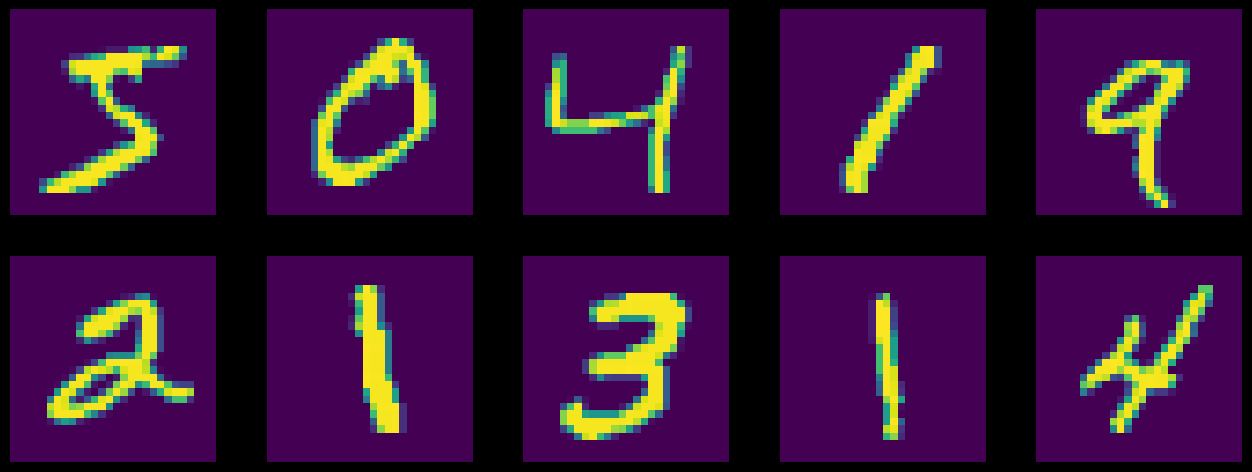

In [7]:
# affichage de quelques images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Création des classes python pour le modèle

In [8]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Fonctionnement sur un GPU 

Dans PyTorch, le passage entre le CPU et le GPU est contrôlé par une chaîne de périphériques, qui déterminera si le GPU est disponible, et reviendra au CPU si ce n'est pas le cas 

In [9]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # envoie au périphérique
        data, target = data.to(device), target.to(device)
        
        # permutation des pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # envoie au périphérique
        data, target = data.to(device), target.to(device)
        
        # permutation des pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Entraîner un petit réseau complètement connecté (fully-connected network)

In [10]:
n_hidden = 8 # nombre d'unités cachées

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Nombre de paramètres: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Nombre de paramètres: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.344525
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.803441
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.166879
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.621501
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.624262
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.662442
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.447071
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.551423
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.446110
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.504793

Test set: Average loss: 0.4321, Accuracy: 8747/10000 (87%)



# Entraîner un ConvNet avec le même nombre de paramètres

In [11]:
# Paramètres d'entraînement settings 
n_features = 6 # nombre de cartes de caractéristiques (feature maps)

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Nombre de paramètres: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Nombre de paramètres: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308184
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.045851
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.581624
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.215426
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.209384
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.416284
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.176216
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.101234
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.225707
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.178389

Test set: Average loss: 0.1554, Accuracy: 9495/10000 (95%)



# Le ConvNet est plus performant avec le même nombre de paramètres que le réseau complètement connecté, grâce à l'utilisation de connaissances préalables sur les images

* Utilisation de la convolution : Localité et stationnarité dans les images
* Le pooling : intégrer une certaine invariance dans la translation

# Que se passe-t-il si les hypothèses ne sont plus vraies ?

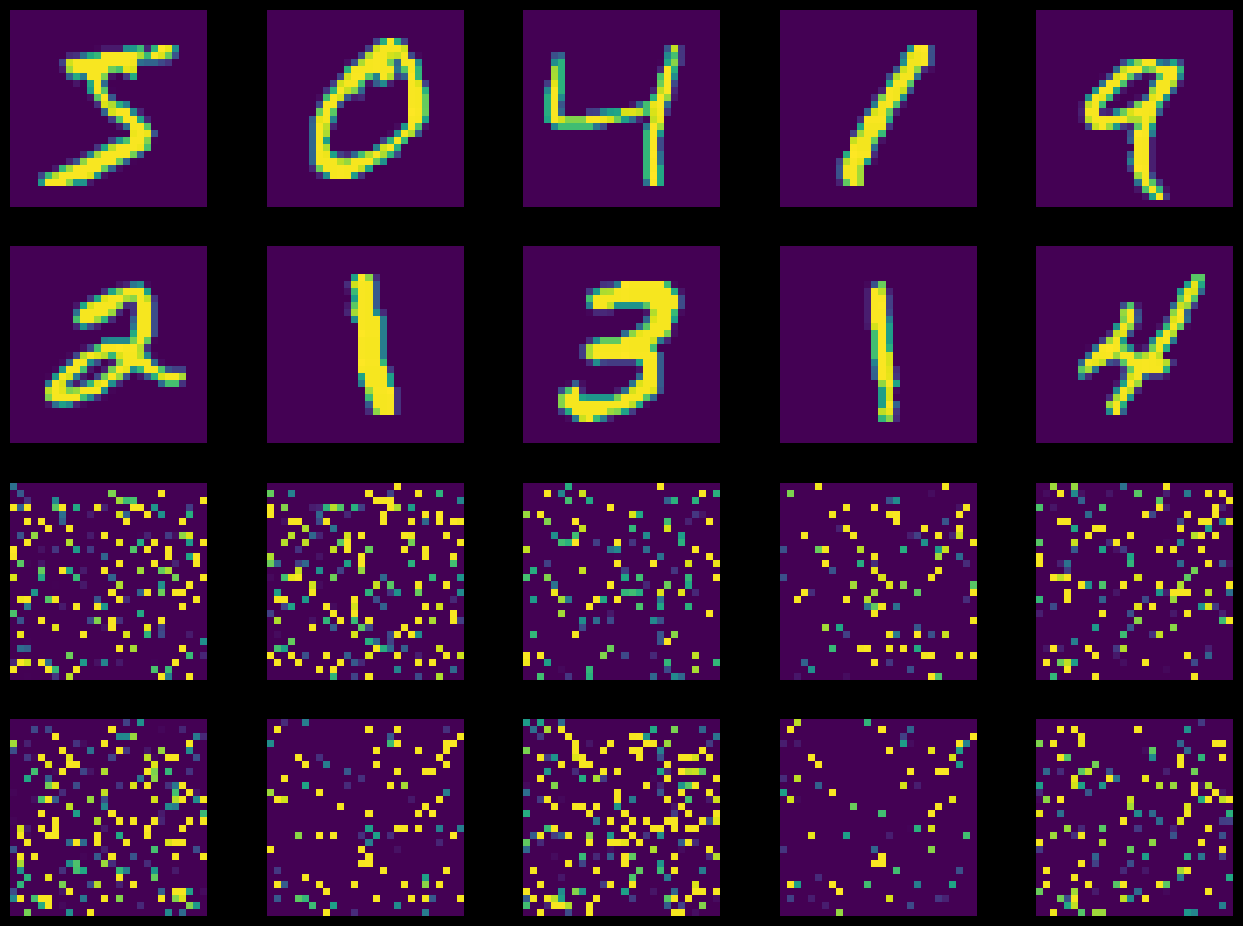

In [12]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permutation des pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet avec  pixels permutés

In [13]:
# Paramètres d'entraînement settings 
n_features = 6 # nombre de cartes de caractéristiques (feature maps)

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Nombre de paramètres: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Nombre de paramètres: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.350882
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.226252
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.034557
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.669648
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.318518
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.087838
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.758893
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.680550
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.662649
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.419346

Test set: Average loss: 0.5238, Accuracy: 8378/10000 (84%)



# Fully-Connected avec  pixels permutés

In [14]:
n_hidden = 8    # nombres d'unités cachées

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Nombre de paramètres: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Nombre de paramètres: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.295888
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.538405
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.975974
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.593560
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.670886
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.537673
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.423191
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.502980
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.518922
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.632382

Test set: Average loss: 0.3881, Accuracy: 8858/10000 (89%)



# La performance du ConvNet diminue lorsque nous permutions les pixels, mais celle du Fully-Connected Network reste la même

* ConvNet part du principe que les pixels se trouvent sur une grille et sont stationnaires/locaux
* Ses performances baissent lorsque cette hypothèse est fausse
* Le réseau entièrement connecté ne fait pas cette hypothèse
* Il se porte moins bien quand c'est vrai, car il ne tire pas parti de ces connaissances préalables
* Cependant il ne souffre pas lorsque l'hypothèse est fausse

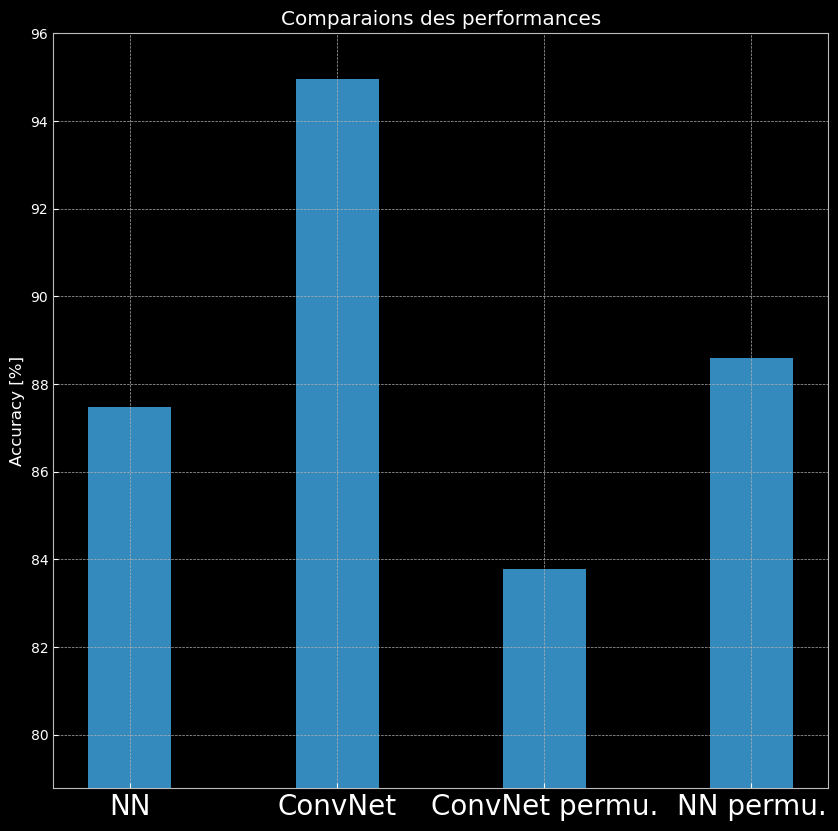

In [21]:
plt.bar(('NN', 'ConvNet',
         'ConvNet permu.', 'NN permu.'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Comparaions des performances');

### Vérification des paramètres des modèles

In [22]:
print(dir(model_cnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'conv1', 'conv2', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'fc1', 'fc2', 'float', 'forward', 'half', 'load_state_dict', 'modules', 'n_feature', 'named_buffers', 'name

In [23]:
print(dir(model_fnn))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'half', 'input_size', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'named_modules', '